# Assignment 2

### Import libraries

In [27]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pickle

### Categorical Cross entropy 

In [2]:
 # Multi-class categorical crossentropy
def categorical_crossentropy(y,y_hat):
    elem = np.multiply(y,y_hat)
    probs = np.max(elem,axis=1) #dim n samples
    n_samples = probs.shape[0]
    loss = np.sum(-np.log(probs))/n_samples
    return (loss,probs)

### Sigmoid Function

In [3]:
# Sigmoid activation function
def sigmoid(x):
    net = 1/(1 + np.exp(-x))
    return net

### Softmax Function

In [4]:
def softmax(x):
    s = np.exp(x - np.max(x))
    return s / s.sum(axis=0)

### Gates 

In [5]:
# Multiplication gate class
class MultGate():
    def forward(self,x,y):
        z = np.dot(y,x)
        self.x = x
        self.y = y
        return z
    def backward(self,dz):
        dx = np.dot(dz.T,self.y).T
        dy = np.dot(dz,self.x.T)
        return [dx,dy]

In [6]:
# Sigmoid gate class
class SigmoidGate():
    def forward(self,x):
        self.z = sigmoid(x)
        return self.z
    def backward(self,dz):
        dx = (self.z * (1 - self.z)) * dz
        return dx

In [7]:
# Softmax gate class
class SoftmaxGate():
    def forward(self,x):
        self.z = softmax(x)
        return self.z
    def backward(self,dz):
        #self.z = self.z.T
        #diagonal_mat = np.zeros(self.z.shape)
        #np.fill_diagonal(diagonal_mat,1)
        #dx = np.multiply((self.z * (diagonal_mat - self.z)),dz.T).T
        #self.z = self.z.T
        return dz

In [8]:
class LossGate():
    def forward(self,y_true,y_prob,batch_size):
        self.y_prob = y_prob
        self.y_true = y_true
        self.loss = - (1/batch_size) * np.sum(y_true * np.log(y_prob))
        return self.loss
    def backward(self):
        return self.y_prob - self.y_true

In [9]:
class Model(): #n unit hiddens, activation function
    def __init__(self, input_shape, layer_dims):    
        
        np.random.seed(8)
        self.w0 = np.random.randn(layer_dims[0],input_shape) * 0.1
    
        parameters = {}
        
        for i in range(1,len(layer_dims)):
            parameters['W{}'.format(i)] = np.random.randn(layer_dims[i],layer_dims[i-1]) * 0.1
        
        self.w1 = parameters['W1']
        self.w2 = parameters['W2']
      
        
        #print('self.w0.shape = {}'.format(self.w0.shape))
        #print('self.w1.shape = {}'.format(self.w1.shape))
        #print('self.w2.shape = {}'.format(self.w2.shape))

        #Layer 1
        self.nn = []
        self.nn.append(MultGate())
        self.nn.append(SigmoidGate())
        
        #Layer 2
        self.nn.append(MultGate())
        self.nn.append(SigmoidGate())
        
        #Layer 3
        self.nn.append(MultGate())
        self.nn.append(SoftmaxGate())
        
        self.nn.append(LossGate())


        
    def forward(self,x,y,batch_size):
        
        # Layer 1
        fwd0 = self.nn[0].forward(x,self.w0) # MultGate
        h0 = self.nn[1].forward(fwd0) #Sigmoid
        
        # Layer 2
        fwd1 = self.nn[2].forward(h0,self.w1) # MultGate
        h1 = self.nn[3].forward(fwd1) #Sigmoid
        
        # Layer 3
        fwd2 = self.nn[4].forward(h1,self.w2) # MultGate
        y_prob = self.nn[5].forward(fwd2) #Softmax
        
        loss = self.nn[6].forward(y,y_prob,batch_size)
        
        return [loss,y_prob]
    
    def backward(self):
        
        gradLoss = self.nn[6].backward() #LossGate

        # Layer 3
        gradSoftmax = self.nn[5].backward(gradLoss)
        dh1, self.dw2 = self.nn[4].backward(gradSoftmax)
        
        # Layer 2
        gradSigmoid = self.nn[3].backward(dh1)
        dh0, self.dw1 = self.nn[2].backward(gradSigmoid)
        
        # Layer 1
        gradSigmoid = self.nn[1].backward(dh0)
        dx, self.dw0 = self.nn[0].backward(gradSigmoid)
        
    def update_params(self,learning_rate):
        self.w0 -= learning_rate * self.dw0
        self.w1 -= learning_rate * self.dw1
        self.w2 -= learning_rate * self.dw2
    

    def fit(self,x_train,y_train,x_val,y_val,learning_rate,batch_size,epochs):
        
        n_samples = x_train.shape[0]
        val_nsamples = x_val.shape[0]
        
        n_batches = n_samples // batch_size
        index_batches = []
        
        loss_epochs = []
        acc_epochs = []
        val_loss_epochs = []
        val_acc_epochs = []
        
        #Sliding the data in batches
        index = range(n_samples)
        for i in range(n_batches):
            index_batches.append(index[i * batch_size : (i + 1) * batch_size])
            
        assert(len(index_batches) == n_batches)
        
        
        for epoch in range(epochs):
            
            loss_batch = []
            acc_batch = []
            val_loss_batch = []
            val_acc_batch = []
            
            for i in range(n_batches):
                
                batch_index = index_batches[i]
                batch_x = x_train[batch_index,:]
                batch_y = y_train[batch_index,:]
               
                loss,y_prob = self.forward(batch_x.T,batch_y.T,batch_size)
                loss_batch.append(loss)
                acc = self.evaluation(batch_y,y_prob.T,batch_size)
                acc_batch.append(acc)
                self.backward()
                self.update_params(learning_rate)
                
                loss,y_prob = self.forward(x_val.T,y_val.T,val_nsamples)
                val_loss_batch.append(loss)
                acc = self.evaluation(y_val,y_prob.T,val_nsamples)
                val_acc_batch.append(acc)
                
            
            loss_epochs.append(np.mean(loss_batch))
            acc_epochs.append(np.mean(acc_batch))
            
            val_loss_epochs.append(np.mean(val_loss_batch))
            val_acc_epochs.append(np.mean(val_acc_batch))
                

        results = {}
        results['train'] = {}
        results['train']['loss'] = loss_epochs
        results['train']['acc'] = acc_epochs
        results['val'] = {}
        results['val']['loss'] = val_loss_epochs
        results['val']['acc'] = val_acc_epochs
        return results
        
    def evaluation(self,y_true,y_prob,n_samples):
        idx = np.argmax(y_prob, axis=1)
        y_pred = np.zeros(y_prob.shape) #predicted labels
        y_pred[np.arange(y_prob.shape[0]), idx] = 1

        well_predicted = 0
   
        for i in range(y_true.shape[0]):
            n_trues = np.sum(y_true[i,:] == y_pred[i,:])
            if n_trues == 3:
                well_predicted += 1
        acc = well_predicted/n_samples
        return acc       

    def predict(self,x_test,y_test):
        n_samples = x_test.shape[0]
        loss, y_prob = self.forward(x_test.T,y_test.T,n_samples)
        acc = self.evaluation(y_test,y_prob.T,n_samples)
        print("Loss: {}".format(loss))
        print("Accuracy: {}".format(acc))





## Load Vertebral column dataset and test model
URL: http://archive.ics.uci.edu/ml/datasets/vertebral+column

The goal is to classify if the vertebral column is normal or has any problem by 6 given attributes.

In [13]:
def load_vertebral_column_data (test_size,val_size,random_seed=32):

    df = pd.read_csv('column_3C.dat',header = None, sep = ' ')
    df = shuffle(df, random_state = random_seed)
    test_size = round(df.shape[0]*test_size)

    df = df.values
    x_test = df[ : test_size , : df.shape[1]-1]
    y_test_orig = df[ : test_size, (df.shape[1]-1) : ]
    x_train=df[test_size: ,: df.shape[1]-1]
    y_train_orig=df[test_size: ,(df.shape[1]-1) :]
    
    
    x_train=x_train.astype('float32')
    x_test=x_test.astype('float32')
    
    mean=np.mean(x_train, axis=0)
    std = np.std(x_train, axis=0)
    x_train-=mean
    x_train /=std

    x_test-=mean
    x_test/=std
    
    
    #Validation Set
    val_size = round(x_train.shape[0]*val_size)
    x_val = x_train[:val_size,:]
    y_val_orig = y_train_orig[:val_size,:]
    x_train = x_train[val_size:,:]
    y_train_orig = y_train_orig[val_size:,:]
    
    
   
    
    y_train = np.zeros((y_train_orig.shape[0],3))
    y_val = np.zeros((y_val_orig.shape[0],3))
    y_test = np.zeros((y_test_orig.shape[0],3))

    y_train[(y_train_orig == 'NO')[:,0]] = [1,0,0]
    y_train[(y_train_orig == 'DH')[:,0]] = [0,1,0]
    y_train[(y_train_orig == 'SL')[:,0]] = [0,0,1]
    
    y_val[(y_val_orig == 'NO')[:,0]] = [1,0,0]
    y_val[(y_val_orig == 'DH')[:,0]] = [0,1,0]
    y_val[(y_val_orig == 'SL')[:,0]] = [0,0,1]
    
    y_test[(y_test_orig == 'NO')[:,0]] = [1,0,0]
    y_test[(y_test_orig == 'DH')[:,0]] = [0,1,0]
    y_test[(y_test_orig == 'SL')[:,0]] = [0,0,1]
    
    



    return x_train, y_train, x_val, y_val, x_test, y_test

In [14]:
x_train, y_train, x_val, y_val, x_test, y_test = load_vertebral_column_data(test_size=0.2,val_size=0.2)

In [15]:
x_train.shape

(198, 6)

### Create Model 1

In [16]:
model1 = Model(6,[5,4,3])

In [17]:
history1 = model1.fit(x_train=x_train,y_train=y_train,x_val=x_val,y_val=y_val,learning_rate=0.01,batch_size = 3,epochs=750)


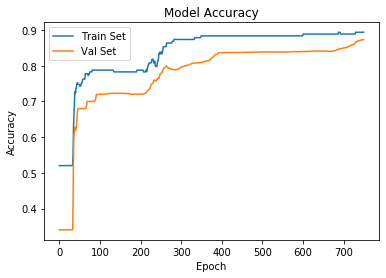

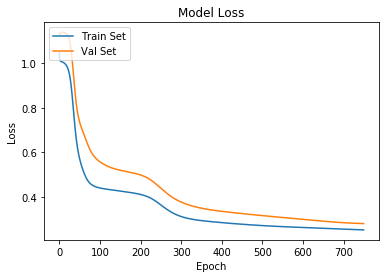

 Train Loss: 0.25311126401589035
 Train Accuracy: 0.8939393939393938
 Validation Loss: 0.2814696377924707
 Validation Accuracy: 0.873030303030303


In [18]:
plt.plot(history1['train']['acc'])
plt.plot(history1['val']['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.legend(['Train Set','Val Set'], loc='upper left')
plt.xlabel('Epoch')

plt.show()

plt.plot(history1['train']['loss'])
plt.plot(history1['val']['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.legend(['Train Set','Val Set'], loc='upper left')
plt.xlabel('Epoch')

plt.show()

acc_train = history1['train']['acc'][-1]
loss_train =  history1['train']['loss'][-1]
print(" Train Loss: {}".format(loss_train))
print(" Train Accuracy: {}".format(acc_train))

acc_val = history1['val']['acc'][-1]
loss_val =  history1['val']['loss'][-1]
print(" Validation Loss: {}".format(loss_val))
print(" Validation Accuracy: {}".format(acc_val))

In [19]:
model1.predict(x_test, y_test)


Loss: 0.3745774955825199
Accuracy: 0.8870967741935484


## Load Iris dataset and test model
URL: https://archive.ics.uci.edu/ml/datasets/Iris

The goal is to classify three different Iris plants depending on 4 attributes:

*   Sepal length
*   Sepal width
*   Petal length
*   Petal width

The goal is to classify the following classes:


1.   Iris Setosa (0)
2.   Iris Versicolour (1)
3.   Iris Virginica (2)










In [20]:
def load_iris_data(test_size,val_size,random_seed = 8):
   
    df = pd.read_csv('iris.data',header=None, sep=',')
    df = shuffle(df, random_state = random_seed)
    test_size = round(df.shape[0]*test_size)
    
    df = df.values
    x_test = df[ : test_size , : df.shape[1]-1]
    y_test_orig = df[ : test_size, (df.shape[1]-1) : ]
    x_train=df[test_size: ,: df.shape[1]-1]
    y_train_orig=df[test_size: ,(df.shape[1]-1) :]
    
    x_train=x_train.astype('float32')
    x_test=x_test.astype('float32')
    
    mean=np.mean(x_train, axis=0)
    std = np.std(x_train, axis=0)
    x_train-=mean
    x_train /=std

    x_test-=mean
    x_test/=std
    
    #Validation Set
    val_size = round(x_train.shape[0]*val_size)
    x_val = x_train[:val_size,:]
    y_val_orig = y_train_orig[:val_size,:]
    x_train = x_train[val_size:,:]
    y_train_orig = y_train_orig[val_size:,:]
    
    y_train = np.zeros((y_train_orig.shape[0],3))
    y_val = np.zeros((y_val_orig.shape[0],3))
    y_test = np.zeros((y_test_orig.shape[0],3))

    y_train[(y_train_orig == 'Iris-setosa')[:,0]] = [1,0,0]
    y_train[(y_train_orig == 'Iris-versicolor')[:,0]] = [0,1,0]
    y_train[(y_train_orig == 'Iris-virginica')[:,0]] = [0,0,1]
    
    y_val[(y_val_orig == 'Iris-setosa')[:,0]] = [1,0,0]
    y_val[(y_val_orig == 'Iris-versicolor')[:,0]] = [0,1,0]
    y_val[(y_val_orig == 'Iris-virginica')[:,0]] = [0,0,1]
    
    y_test[(y_test_orig == 'Iris-setosa')[:,0]] = [1,0,0]
    y_test[(y_test_orig == 'Iris-versicolor')[:,0]] = [0,1,0]
    y_test[(y_test_orig == 'Iris-virginica')[:,0]] = [0,0,1]
    
    
 
    return x_train, y_train, x_val, y_val, x_test, y_test

In [21]:
x_train, y_train, x_val, y_val, x_test, y_test = load_iris_data(test_size=0.2,val_size=0.2)


### Create Model 2

In [22]:
model2 = Model(4,[5,4,3])

In [23]:
history2 = model2.fit(x_train=x_train,y_train=y_train,x_val=x_val,y_val=y_val,learning_rate=0.01,batch_size=30,epochs=250)

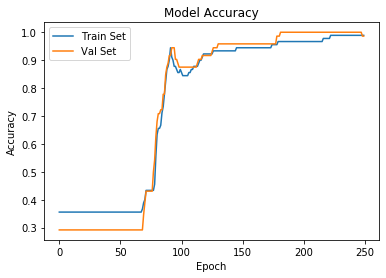

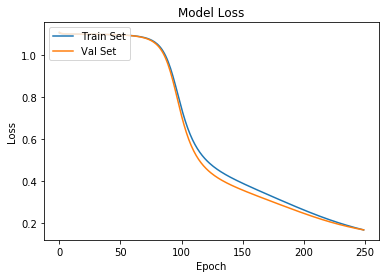

 Train Loss: 0.16769101405433254
 Train Accuracy: 0.9888888888888889
 Validation Loss: 0.16771311964501667
 Validation Accuracy: 0.9861111111111112


In [24]:
plt.plot(history2['train']['acc'])
plt.plot(history2['val']['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.legend(['Train Set','Val Set'], loc='upper left')
plt.xlabel('Epoch')

plt.show()

plt.plot(history2['train']['loss'])
plt.plot(history2['val']['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.legend(['Train Set','Val Set'], loc='upper left')
plt.xlabel('Epoch')

plt.show()

acc_train = history2['train']['acc'][-1]
loss_train =  history2['train']['loss'][-1]
print(" Train Loss: {}".format(loss_train))
print(" Train Accuracy: {}".format(acc_train))

acc_val = history2['val']['acc'][-1]
loss_val =  history2['val']['loss'][-1]
print(" Validation Loss: {}".format(loss_val))
print(" Validation Accuracy: {}".format(acc_val))

In [25]:
model2.predict(x_test, y_test)


Loss: 0.2238685647550359
Accuracy: 0.9333333333333333


### Save Model 1

In [47]:
vertebral_model = 'models/vertebral_model.pkl'
with open(vertebral_model, 'wb') as output:   
        pickle.dump(model1, output, pickle.HIGHEST_PROTOCOL)

### Save Model 2

In [48]:
iris_model = 'models/iris_model.pkl'
with open(iris_model, 'wb') as output:   
        pickle.dump(model2, output, pickle.HIGHEST_PROTOCOL)

### Read Model 1

In [50]:
with open(vertebral_model, 'rb') as input:
    model1 = pickle.load(input)

### Read Model 2

In [49]:
with open(iris_model, 'rb') as input:
    model2 = pickle.load(input)